<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Read-data-saved-by-DataPreprocessing.R" data-toc-modified-id="Read-data-saved-by-DataPreprocessing.R-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read data saved by DataPreprocessing.R</a></span></li></ul></li><li><span><a href="#Model-devolepment" data-toc-modified-id="Model-devolepment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model devolepment</a></span><ul class="toc-item"><li><span><a href="#Split-dataset-to-train-and-test-dataset" data-toc-modified-id="Split-dataset-to-train-and-test-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split dataset to train and test dataset</a></span></li><li><span><a href="#Some-base-function" data-toc-modified-id="Some-base-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Some base function</a></span></li><li><span><a href="#Construction-of-NeuralMultiTaskModel" data-toc-modified-id="Construction-of-NeuralMultiTaskModel-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Construction of NeuralMultiTaskModel</a></span></li><li><span><a href="#Construction-of-NonLinearCoxPHModel-(DeepSurv)" data-toc-modified-id="Construction-of-NonLinearCoxPHModel-(DeepSurv)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Construction of NonLinearCoxPHModel (DeepSurv)</a></span></li><li><span><a href="#Construction-of-RandomSurvivalForestModel" data-toc-modified-id="Construction-of-RandomSurvivalForestModel-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Construction of RandomSurvivalForestModel</a></span></li><li><span><a href="#Construct-CPH-Model" data-toc-modified-id="Construct-CPH-Model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Construct CPH Model</a></span></li><li><span><a href="#Hyperparameters-tuning" data-toc-modified-id="Hyperparameters-tuning-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Hyperparameters tuning</a></span><ul class="toc-item"><li><span><a href="#Tuning-NMTLR" data-toc-modified-id="Tuning-NMTLR-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Tuning NMTLR</a></span></li><li><span><a href="#Tuning-DeepSurv" data-toc-modified-id="Tuning-DeepSurv-2.7.2"><span class="toc-item-num">2.7.2&nbsp;&nbsp;</span>Tuning DeepSurv</a></span></li><li><span><a href="#Tuning-RSF" data-toc-modified-id="Tuning-RSF-2.7.3"><span class="toc-item-num">2.7.3&nbsp;&nbsp;</span>Tuning RSF</a></span></li></ul></li></ul></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metrics</a></span><ul class="toc-item"><li><span><a href="#Generate-data-for-prediction-error-curve" data-toc-modified-id="Generate-data-for-prediction-error-curve-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generate data for prediction error curve</a></span></li><li><span><a href="#Generate-data-for-calibration-curves-and-roc-curves" data-toc-modified-id="Generate-data-for-calibration-curves-and-roc-curves-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data for calibration curves and roc curves</a></span></li><li><span><a href="#Generate-data-for-Loss-converge-graph" data-toc-modified-id="Generate-data-for-Loss-converge-graph-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate data for Loss converge graph</a></span></li><li><span><a href="#Feature-importance-plot" data-toc-modified-id="Feature-importance-plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Feature importance plot</a></span></li><li><span><a href="#Save-models" data-toc-modified-id="Save-models-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Save models</a></span></li></ul></li></ul></div>

# Deep learning models for predicting the survival of patients with chondrosarcoma based on a surveillance, epidemiology, and end results analysis

In [1]:
import torch
import random
import numpy as np
import os
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
SEED = 11122 #random.randint(0,100000)
print(SEED)
seed_everything(SEED)

11122


In [245]:
np.seterr(divide='ignore', invalid='ignore') #Ignore warning: #RuntimeWarning: invalid value encountered in true_divide

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Preprocessing

### Read data saved by DataPreprocessing.R

In [3]:
import pandas as pd
dataset = pd.read_csv('./data/data_surv.csv')
dataset.columns = [name.replace('.',' ') for name in dataset.columns]
time_column = 'Survival months'
event_column = 'Status'
features = np.setdiff1d(dataset.columns, [time_column, event_column]).tolist()
dataset.head()

,Age,Gender,Histological type,Primary site,Grade,Surgery,Tumor size,Tumor extension,Distant metastasis,Survival months,Status
0,44,0,0,1,0,3,81.945378,0,0,213,0
1,51,0,0,1,0,1,70.871131,1,0,208,0
2,72,1,0,0,1,1,87.110515,1,0,19,1
3,59,1,0,0,1,3,112.643443,1,0,216,0
4,25,1,0,0,0,1,50.101888,0,0,219,0


In [4]:
dataset.shape

(3145, 11)

## Model devolepment
### Split dataset to train and test dataset

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
index_train, index_test = train_test_split(range(dataset.shape[0]), test_size = 0.3)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [7]:
data_train.shape, data_test.shape

((2201, 11), (944, 11))

In [252]:
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import RepeatedKFold

### Some base function

In [253]:
class BaseFun:
    def parse_param(self, param):
        for key in param:
            if isinstance(param[key], str):
                param[key] = '"{}"'.format(param[key])
        return ','.join(['{} = {}'.format(key, param[key]) for key in param])
    def get_random_param(self,space):
        param = {}
        for key in space:
            if  key == 'structure':
                items = []
                for i in range(1,random.choice(space['structure']['num_layers'])+1):
                    items.append(
                        {
                        'activation': random.choice(space['structure']['activations']),
                        'num_units':random.choice(space['structure']['num_units'])
                        }
                    )
                param['structure'] = items
            else:
                param[key] = random.choice(space[key])
        return param
    def tuning_and_construct(self,X, T, E,max_iter=100):
        self.tuning_result = self.tuning_with_space(X, T, E,self.space,max_iter=max_iter)
        self.model = self.fit_model(X, T, E,**self.tuning_result['best_param'])
        return self.model
    def tuning_with_space(self,x,t,e,space,max_iter=100):
        [x,t,e] = [item if isinstance(item, np.ndarray) else np.array(item) for item in [x,t,e]]
        scores = []
        best_score = 0
        best_param = {}
        num = 1
        while True:
            param = self.get_random_param(space)
            print('Number {} iteration'.format(num), end=' ... ')
            # split train data to 5 parts
            rkf = RepeatedKFold(n_splits=5, n_repeats=1)
            score_iter = []
            for train_index, test_index in rkf.split(x):
                x_train, x_test = x[train_index], x[test_index]
                t_train, t_test = t[train_index], t[test_index]
                e_train, e_test = e[train_index], e[test_index]
                try:
                    model = self.fit_model(x_train, t_train, e_train,**param)
                    score = concordance_index(model, x_test, t_test, e_test)
                except Exception as err:
                    print(str(err))
                    break
                score_iter.append(score)
            mean_score = np.mean(score_iter)
            print('mean_c_index: ', mean_score, end=' ')
            if mean_score > best_score:
                best_score = mean_score
                best_param = param
                print('is the best so far')
            else:
                print('')
            scores.append({'iteration':num,'mean_score': mean_score, 'param': param})
            if num == max_iter:
                break
            num += 1
        return {'best_param': best_param, 'best_score': best_score, 'scores': scores}

### Construction of NeuralMultiTaskModel

In [255]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
class NMTLR(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'bins' : [i for i in range(10,100)],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 1000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'l2_smooth':[round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        if 'bins' in kwargs:
            bins = kwargs['bins']
            del kwargs['bins']
        self.model = NeuralMultiTaskModel(structure=structure,bins=bins)
        eval('self.model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return self.model

### Construction of NonLinearCoxPHModel (DeepSurv)

In [256]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
class DeepSurv(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 5000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        self.model = NonLinearCoxPHModel(structure=structure)
        eval('self.model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return self.model

### Construction of RandomSurvivalForestModel

In [257]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
class RSF(BaseFun):
    def __init__(self):
        self.space = {
            'num_trees': [i for i in range(20, 1000 + 1)],
            'max_features': ['sqrt', 'log2', 'all', 0.1, 0.2],
            'min_node_size': [i for i in range(5, 80 + 1)],
            'sample_size_pct': [round(0.2 * i, 2) for i in range(1, 4 + 1)],
            'importance_mode': ['impurity', 'impurity_corrected', 'permutation', 'normalized_permutation']
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        if 'num_trees' in kwargs:
            self.model = RandomSurvivalForestModel(num_trees=kwargs['num_trees'])
            del kwargs['num_trees']
        else:
            self.model = ConditionalSurvivalForestModel()
        eval('self.model.fit(X, T, E,seed=SEED,{})'.format(self.parse_param(kwargs)))
        return self.model

### Construct CPH Model

In [258]:
from pysurvival.models.semi_parametric import CoxPHModel
def cph(X_train, T_train, E_train):
    model = CoxPHModel()
    model.fit(X_train, T_train, E_train, lr=0.2, l2_reg=0.01)
    return model


In [259]:
cph_model = cph(X_train, T_train, E_train)
c_index_train = concordance_index(cph_model, X_train, T_train, E_train)
c_index_test = concordance_index(cph_model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 4505.393 - ||grad||^2 = 983.27284
 * Iteration #2 - Loss = 4155.394 - ||grad||^2 = 636.65340
 * Iteration #3 - Loss = 4081.095 - ||grad||^2 = 506.60113
 * Iteration #4 - Loss = 4036.127 - ||grad||^2 = 404.68908
 * Iteration #5 - Loss = 4007.583 - ||grad||^2 = 324.06807
 * Iteration #6 - Loss = 3988.964 - ||grad||^2 = 259.81522
 * Iteration #7 - Loss = 3976.691 - ||grad||^2 = 208.38038
 * Iteration #8 - Loss = 3968.589 - ||grad||^2 = 167.12085
 * Iteration #9 - Loss = 3963.252 - ||grad||^2 = 133.99943
 * Iteration #10 - Loss = 3959.751 - ||grad||^2 = 107.40990
 * Iteration #11 - Loss = 3957.462 - ||grad||^2 = 86.07014
 * Iteration #12 - Loss = 3955.972 - ||grad||^2 = 68.95062
 * Iteration #13 - Loss = 3955.005 - ||grad||^2 = 55.22258
 * Iteration #14 - Loss = 3954.379 - ||grad||^2 = 44.21855
 * Iteration #15 - Loss = 3953.975 - ||grad||^2 = 35.40109
 * Iteration #16 - Loss = 3953.714 - ||grad||^2 = 28.33784
 * Iteration #17

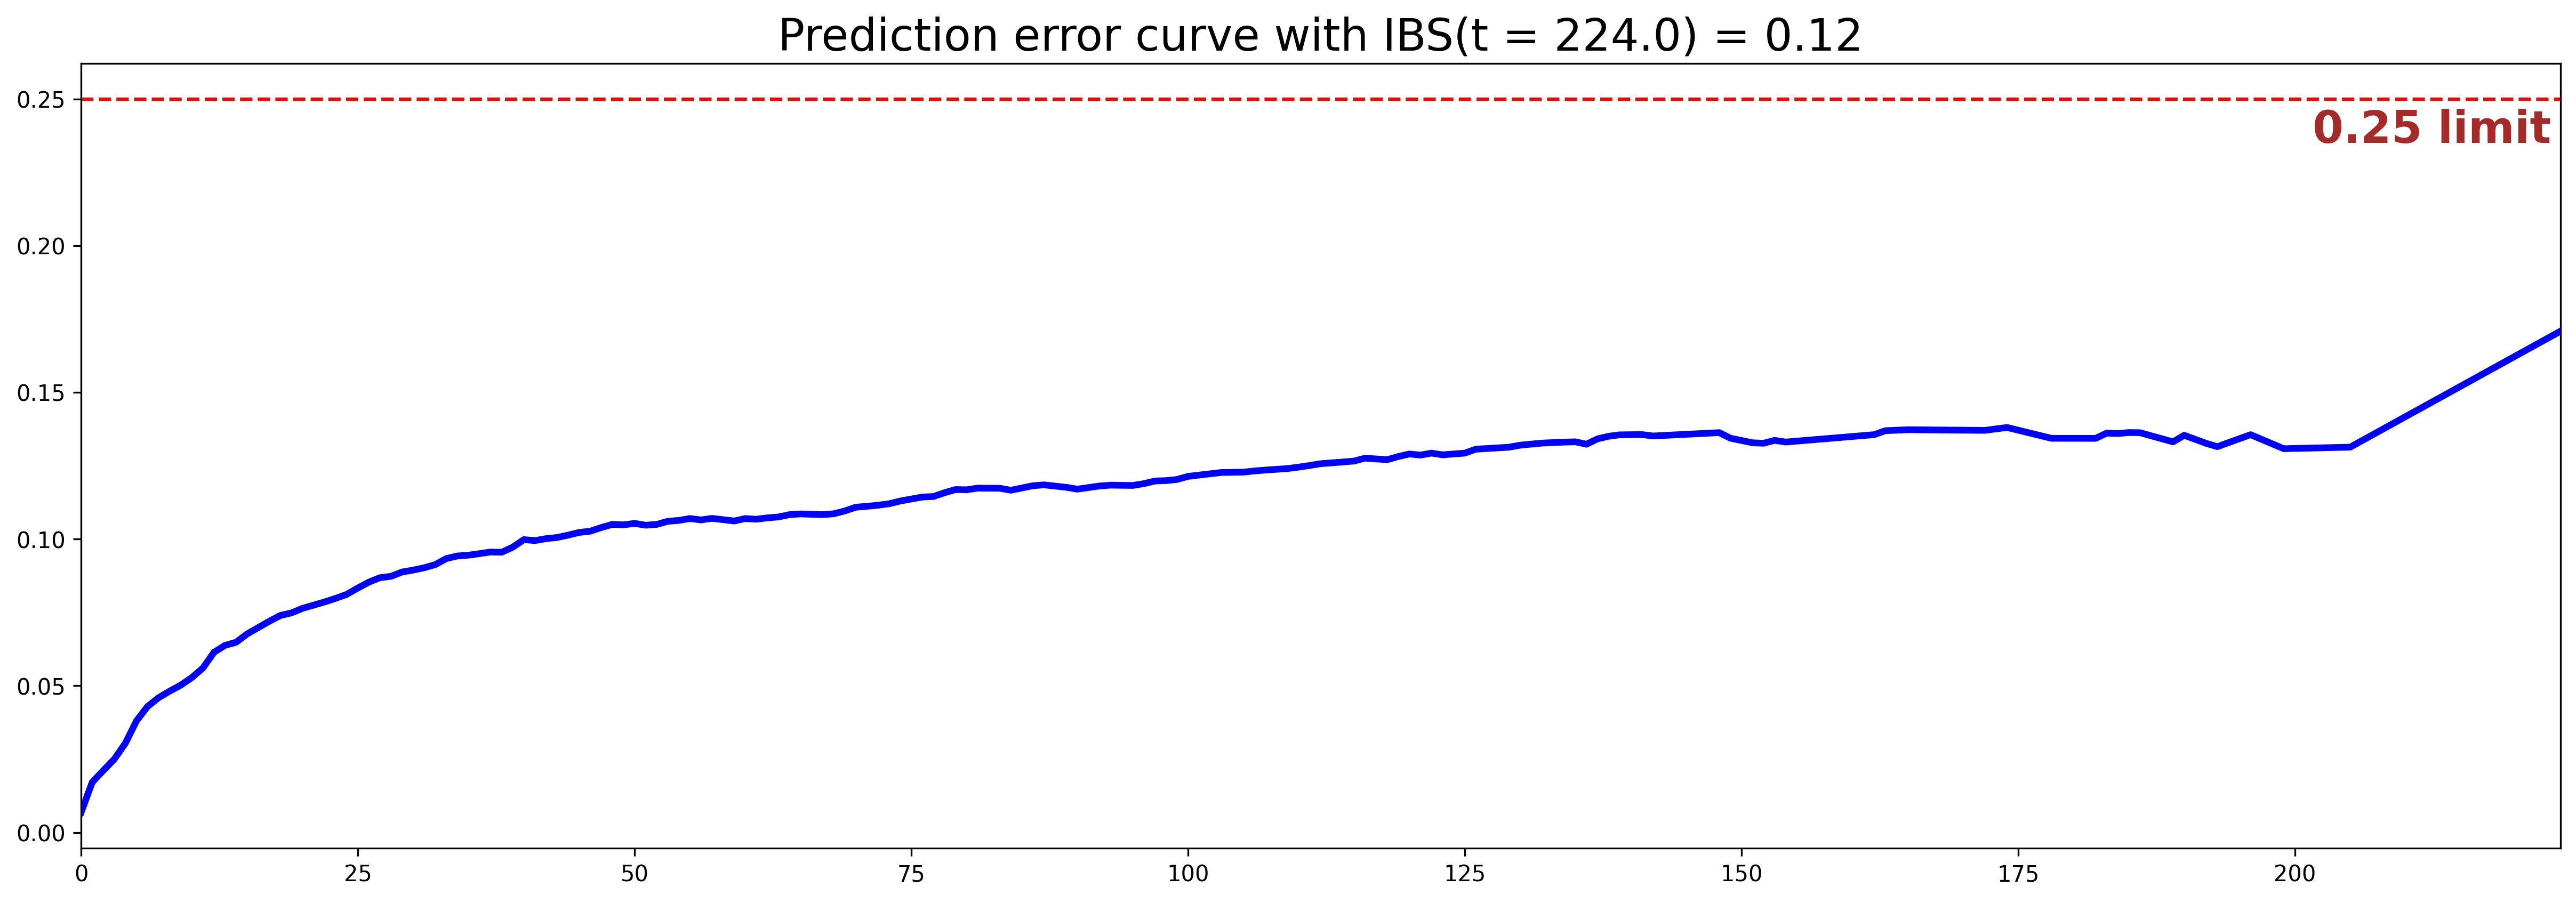

IBS: 0.12


In [260]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(cph_model, X_train, T_train, E_train,t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

### Hyperparameters tuning

In [261]:
max_iter = 1000

#### Tuning NMTLR

In [ ]:
nmtlr = NMTLR()
nmtlr.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)
nmtlr_model = nmtlr.model

⬆️⬆️⬆️ The output of above cell was deleted because it had too many lines of content. The full version can be accessed in the another notebook

In [398]:
c_index_train = concordance_index(nmtlr.model, X_train, T_train, E_train)
c_index_test = concordance_index(nmtlr.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.8490; C-index of test: 0.8207


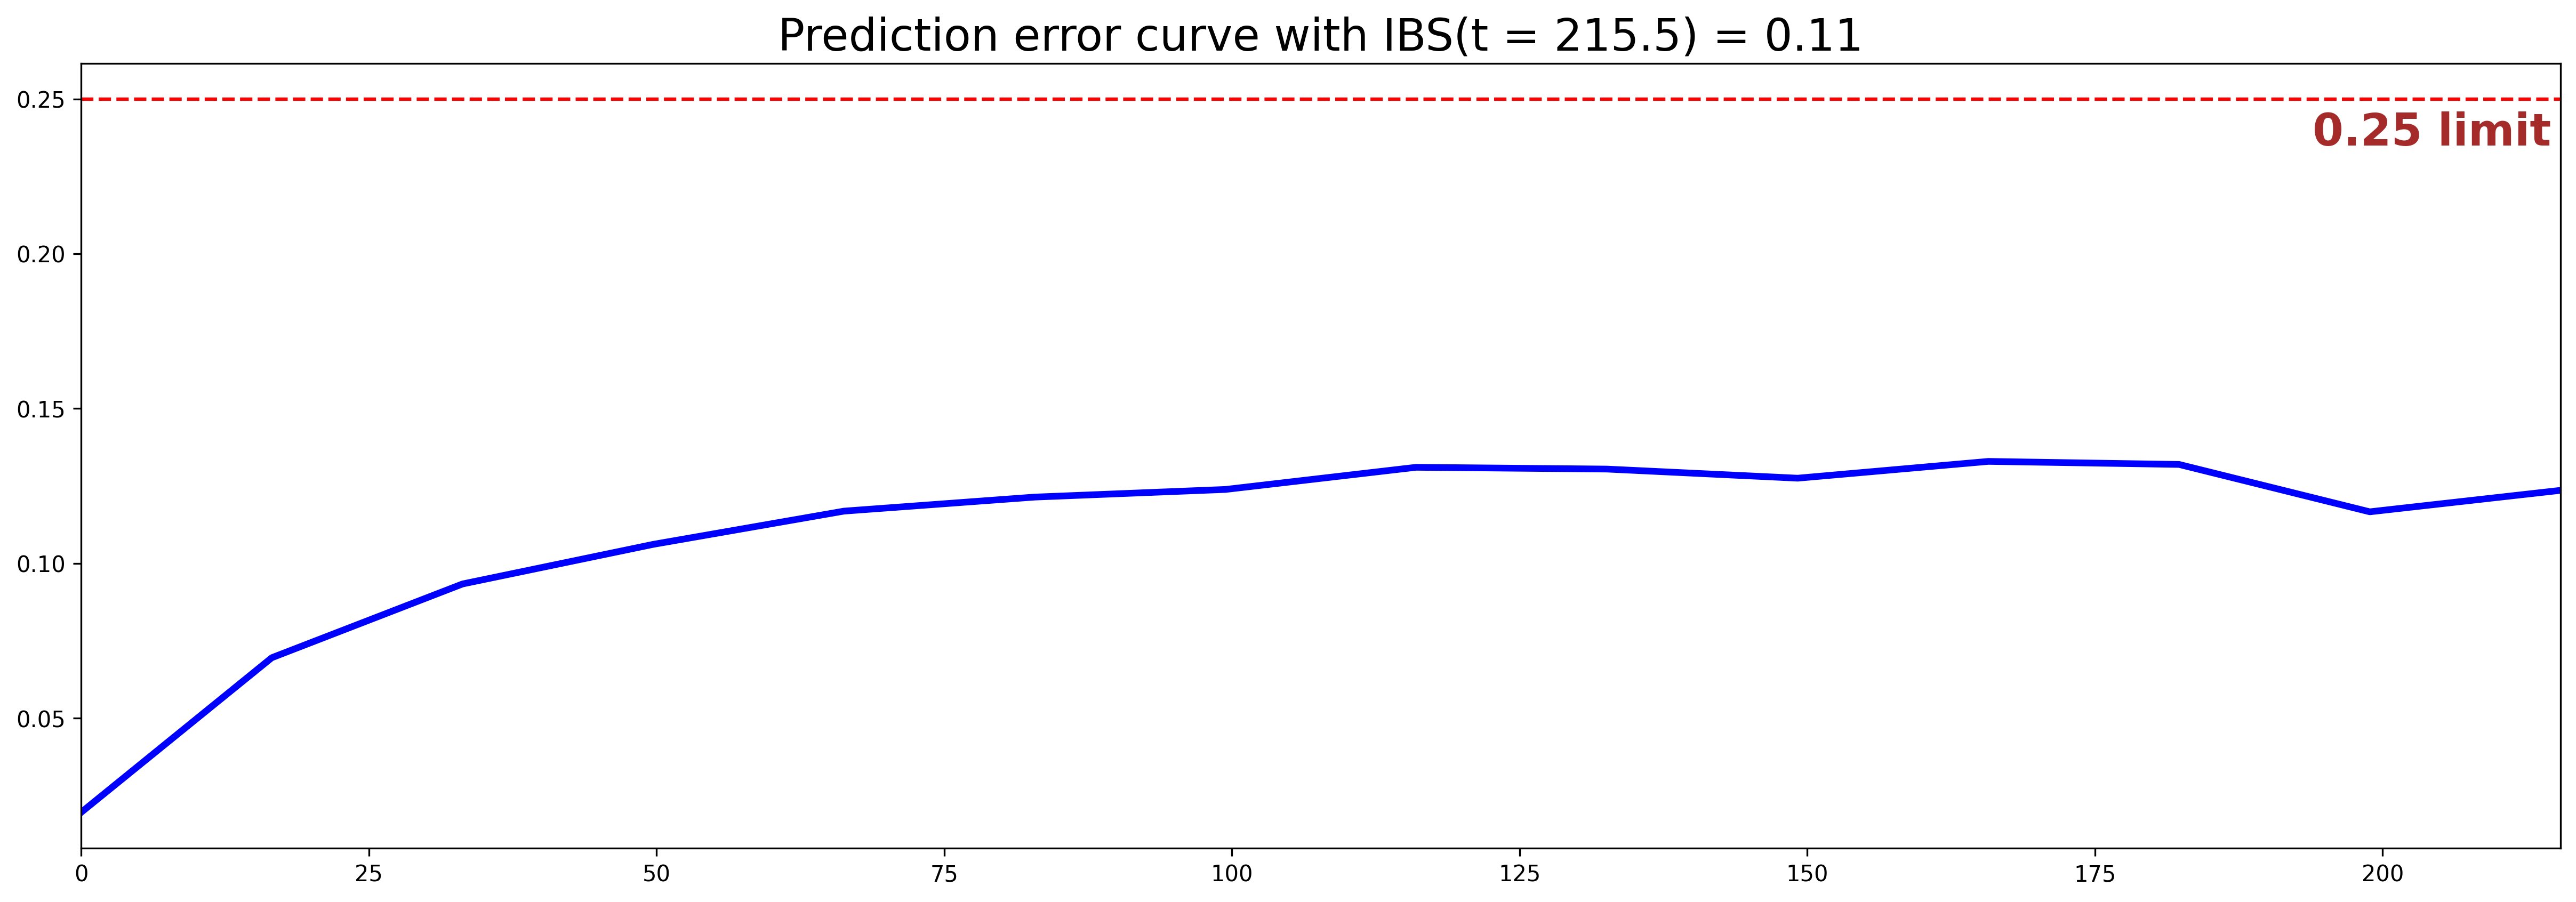

IBS: 0.11


In [399]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(nmtlr.model, X_test, T_test, E_test,figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [400]:
nmtlr.tuning_result['best_param']

{'structure': [{'activation': 'ReLU', 'num_units': 81},
  {'activation': 'InverseSqrt', 'num_units': 47},
  {'activation': 'InverseSqrt', 'num_units': 80}],
 'optimizer': 'rmsprop',
 'bins': 16,
 'lr': 0.00096,
 'num_epochs': 205,
 'dropout': 0.4,
 'l2_reg': 0.0001,
 'l2_smooth': 0.0054,
 'batch_normalization': False}

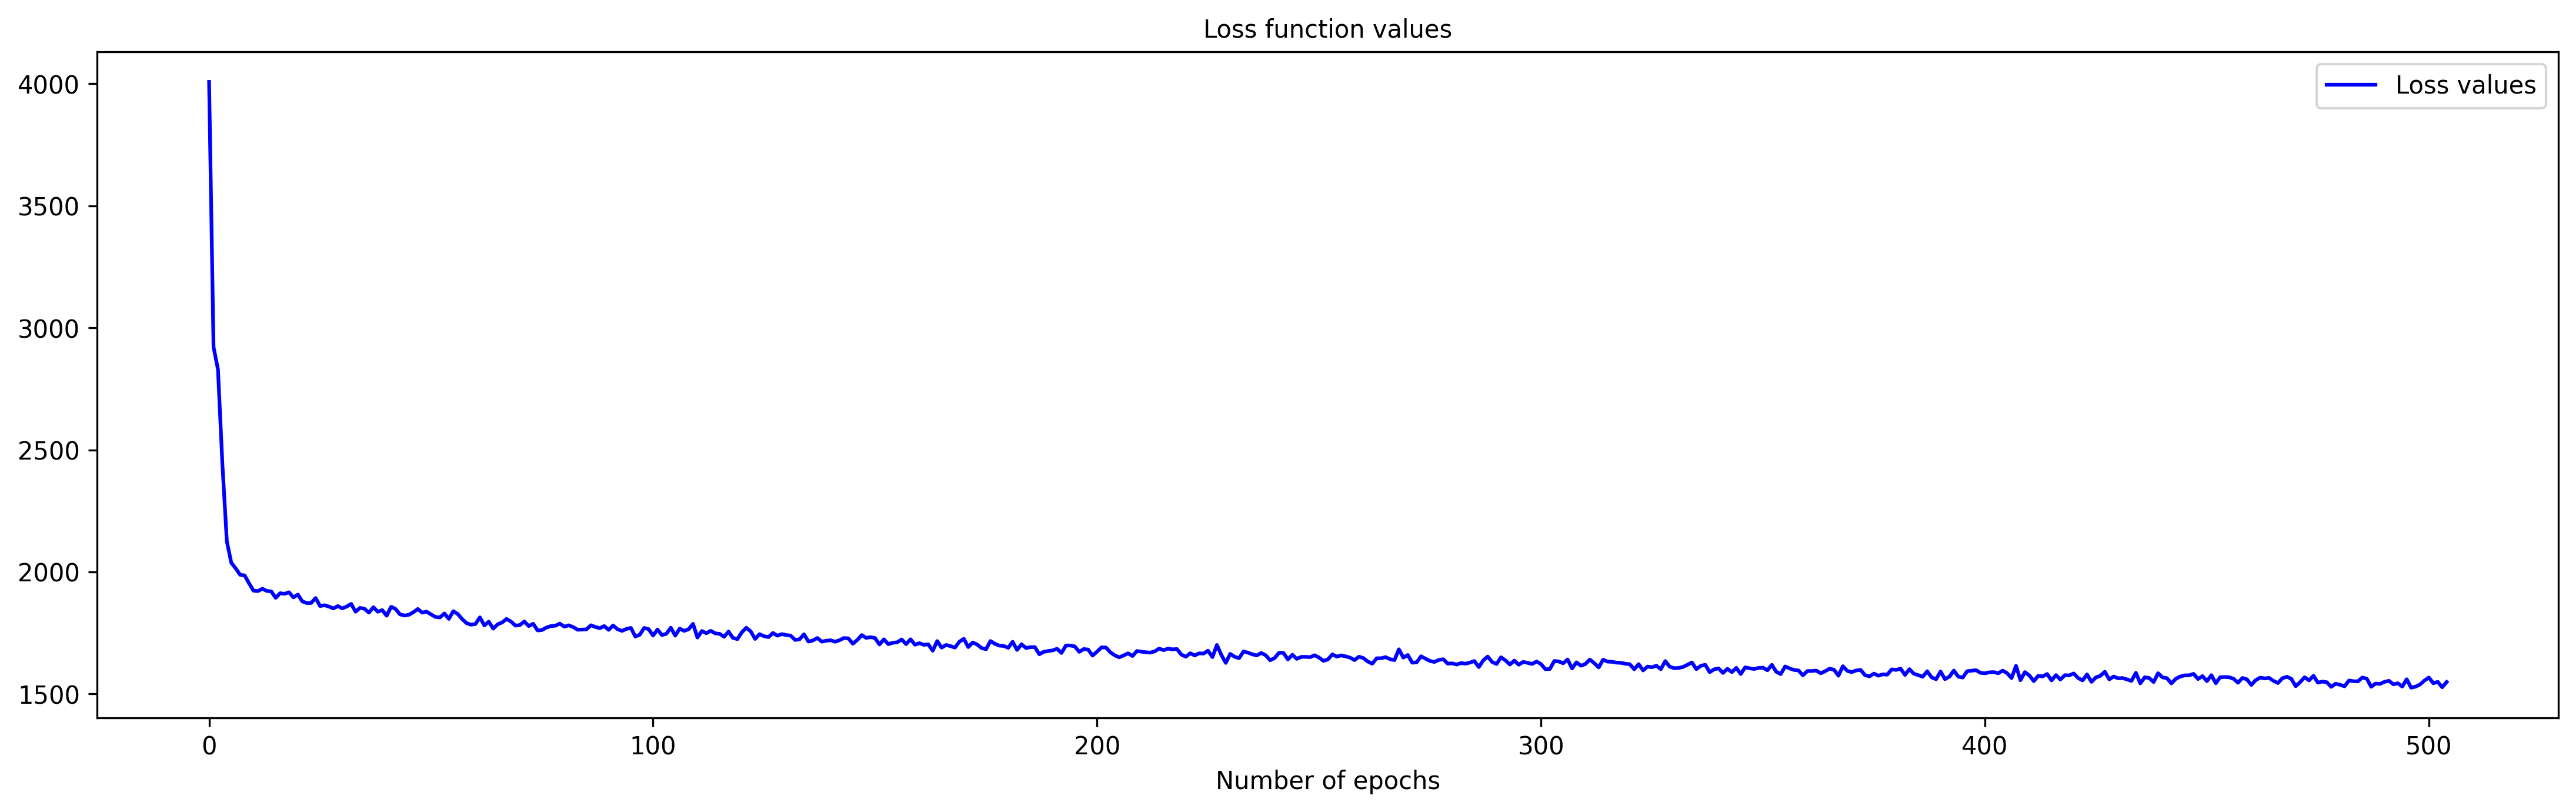

In [402]:
from pysurvival.utils.display import display_loss_values
display_loss_values(nmtlr.model)

#### Tuning DeepSurv

In [ ]:
deepsurv = DeepSurv()
deepsurv.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)
deepsurv_model = deepsurv.model

⬆️⬆️⬆️ The output of above cell was deleted because it had too many lines of content. The full version can be accessed in the another notebook

In [403]:
c_index_train = concordance_index(deepsurv.model, X_train, T_train, E_train)
c_index_test = concordance_index(deepsurv.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.8542; C-index of test: 0.8219


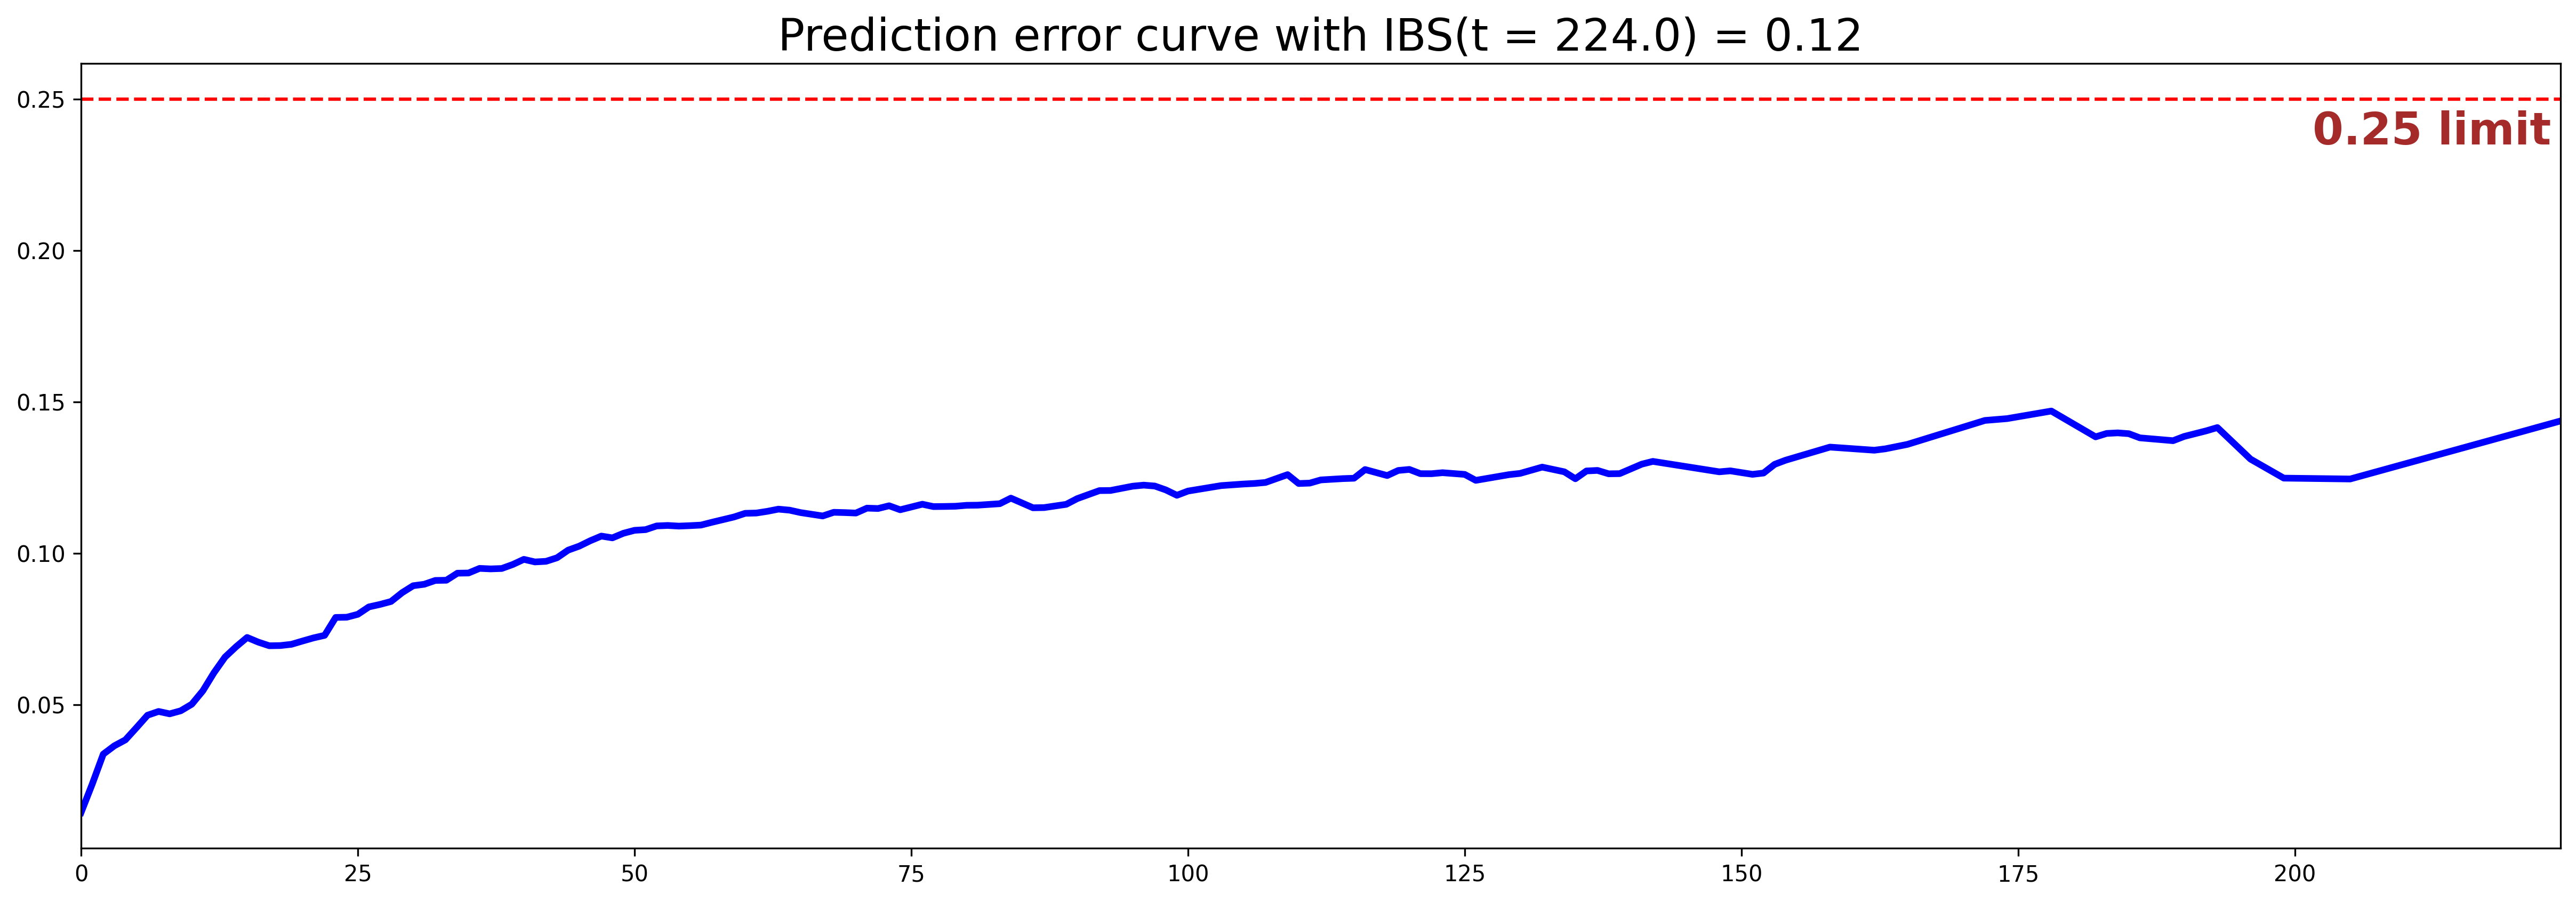

IBS: 0.12


In [404]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(deepsurv.model, X_test, T_test, E_test, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [405]:
deepsurv.tuning_result['best_param']

{'structure': [{'activation': 'ReLU', 'num_units': 68},
  {'activation': 'SinReLU', 'num_units': 85}],
 'optimizer': 'sgd',
 'lr': 0.00026,
 'num_epochs': 2471,
 'dropout': 0.4,
 'l2_reg': 0.0084,
 'batch_normalization': False}

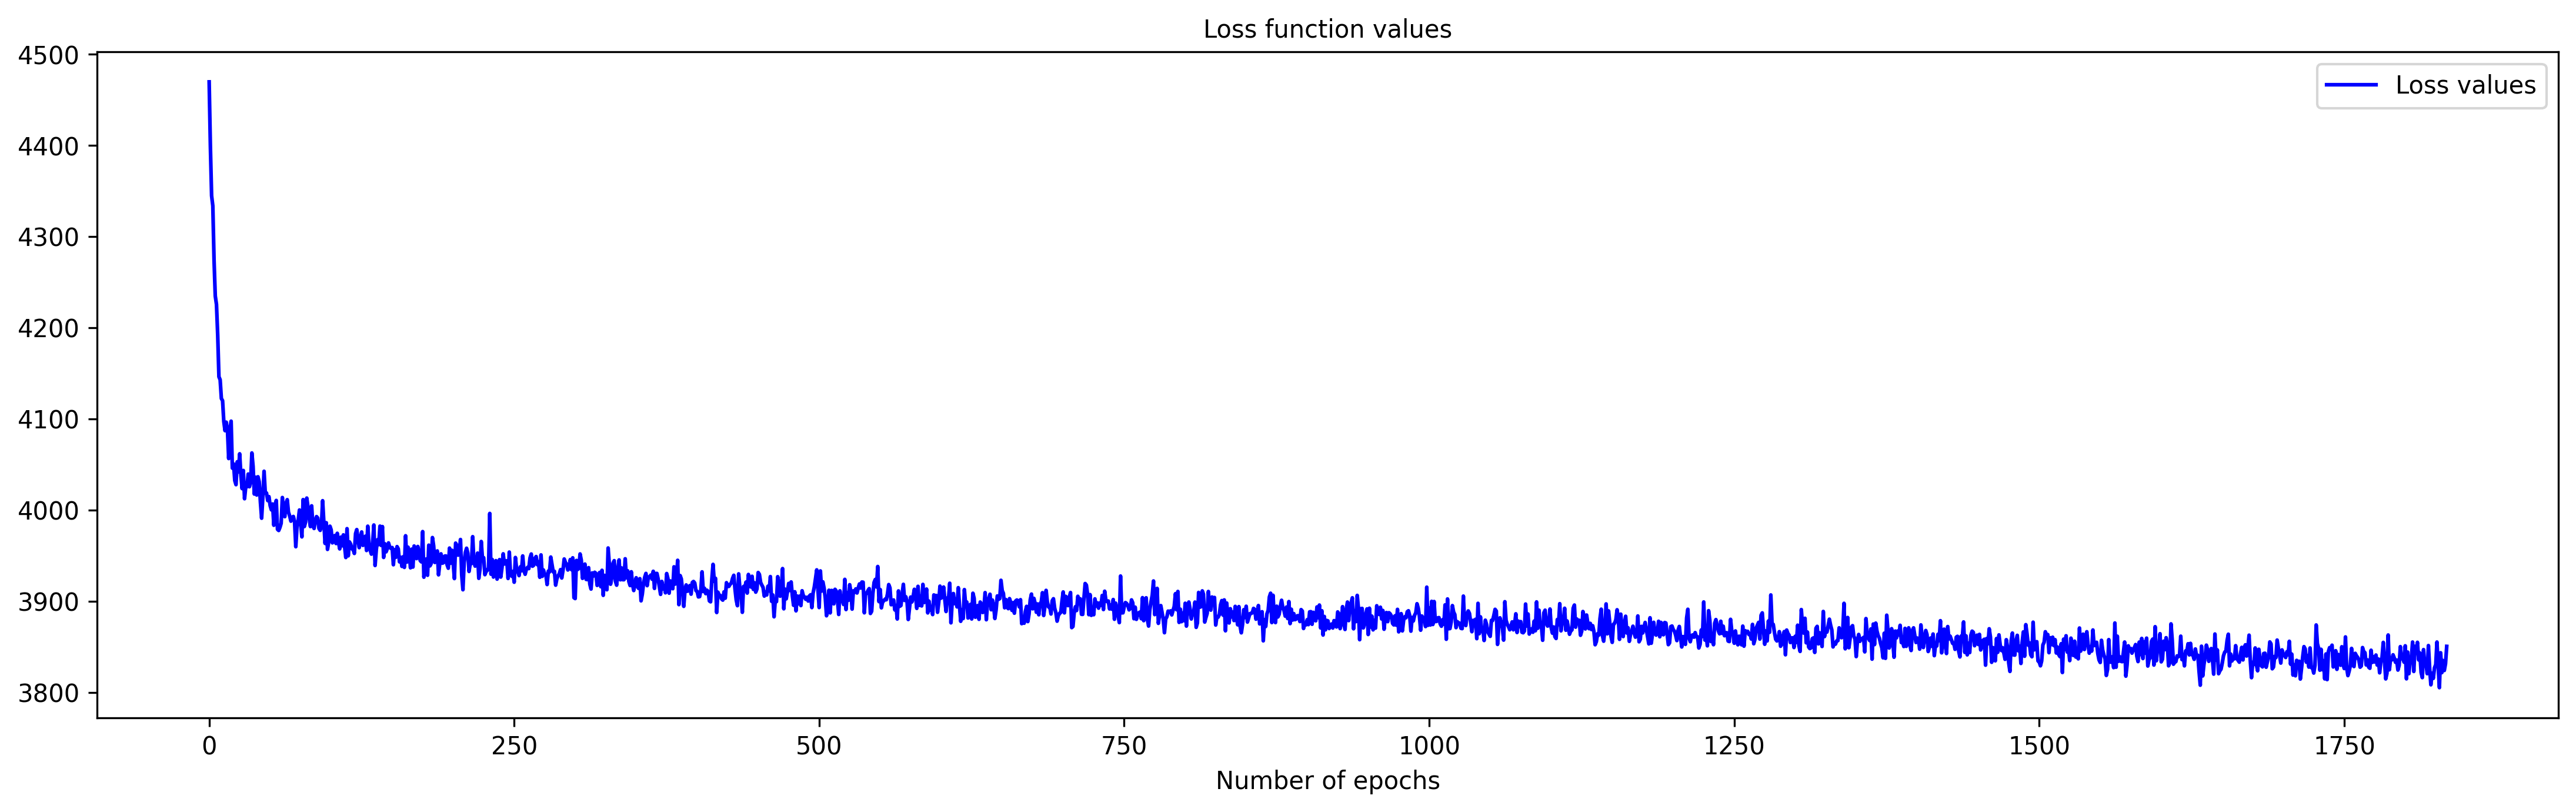

In [277]:
display_loss_values(deepsurv.model)

#### Tuning RSF

In [ ]:
rsf = RSF()
rsf.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)
rsf_model = rsf.model
c_index = concordance_index(rsf_model, X_test, T_test, E_test)
print('C-index: {:.4f}'.format(c_index))# C-index: 0.7236

⬆️⬆️⬆️ The output of above cell was deleted because it had too many lines of content. The full version can be accessed in the another notebook

In [406]:
c_index_train = concordance_index(rsf.model, X_train, T_train, E_train)
c_index_test = concordance_index(rsf.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.8288; C-index of test: 0.8029


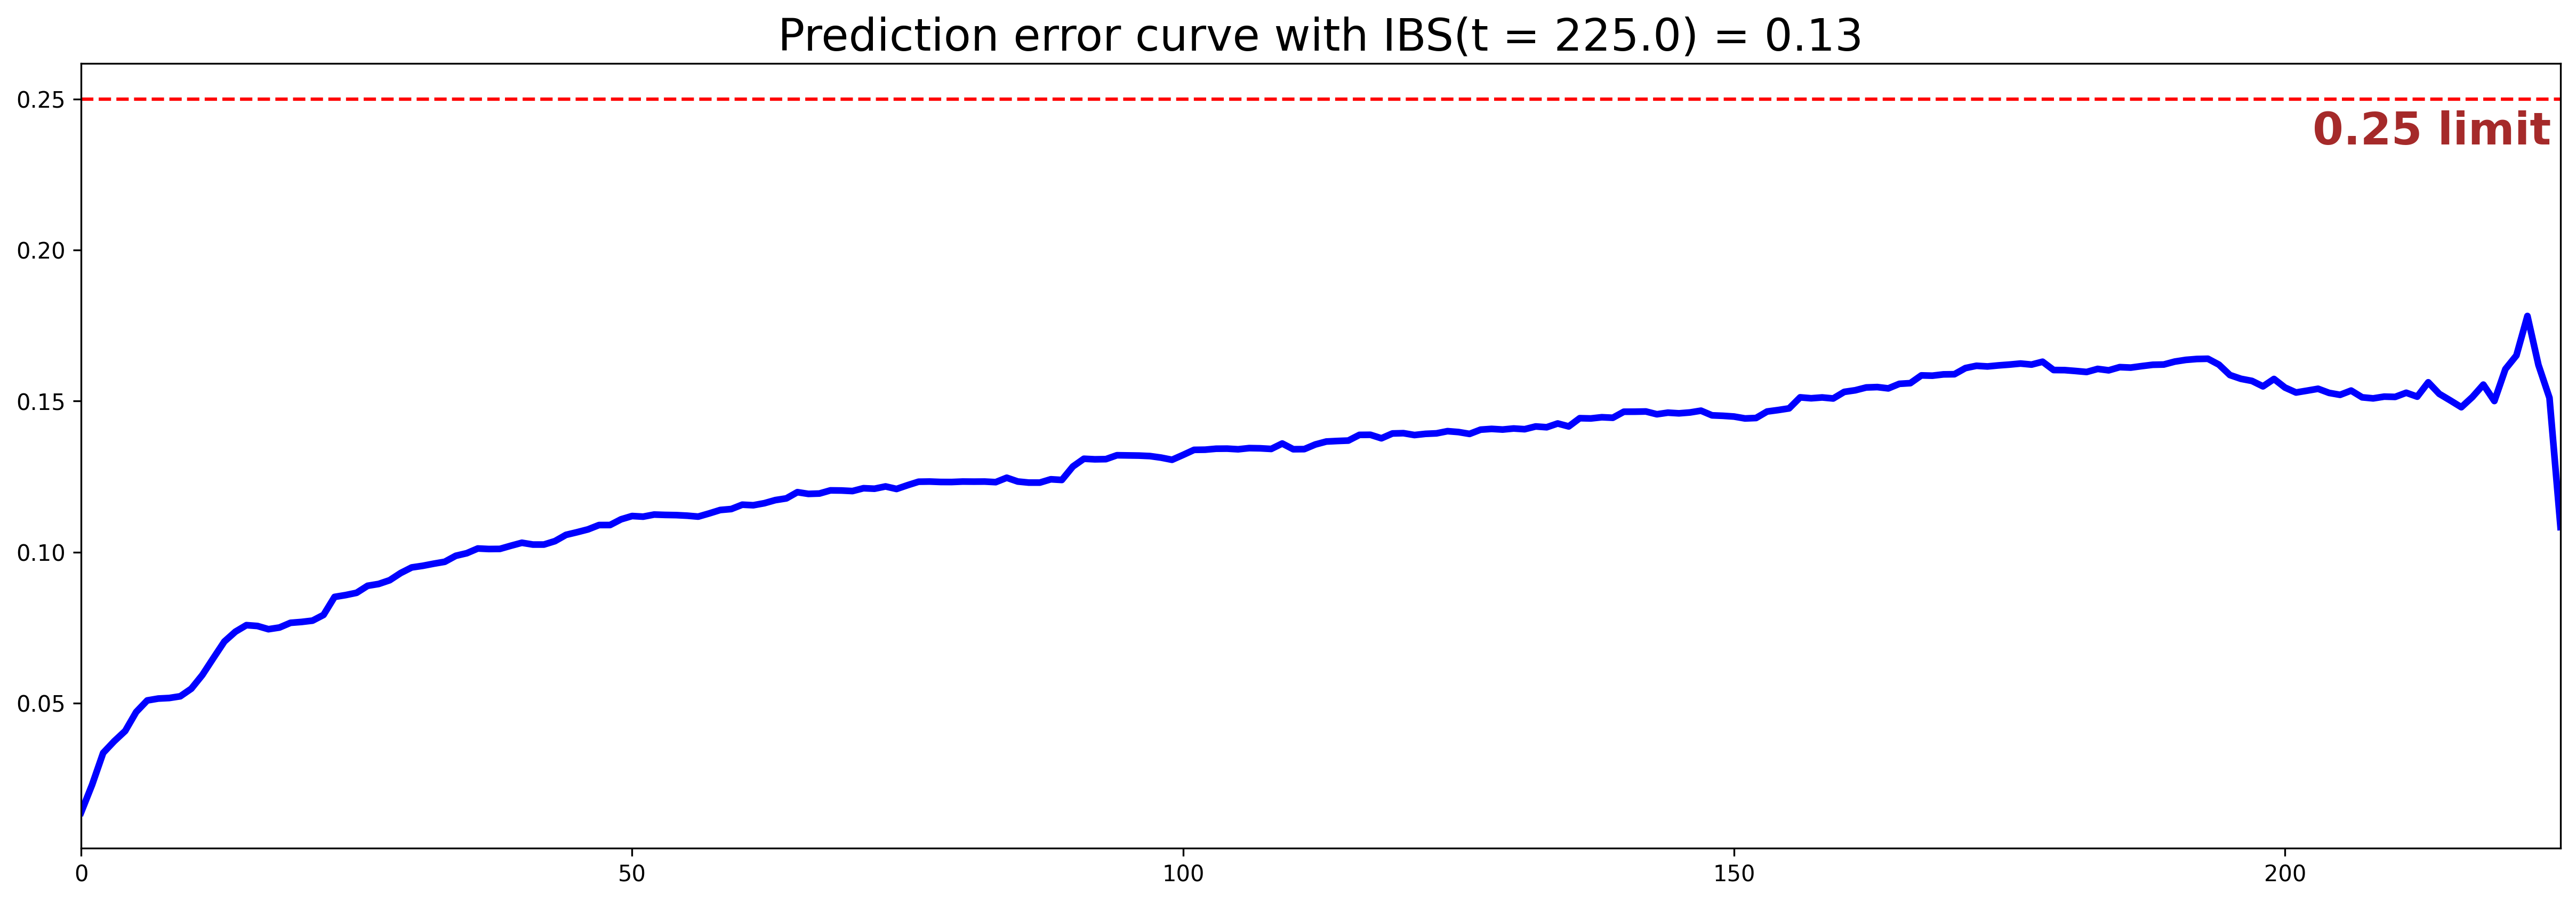

IBS: 0.13


In [407]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(rsf.model, X_test, T_test, E_test, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [282]:
rsf.tuning_result['best_param']

{'num_trees': 491,
 'max_features': 'log2',
 'min_node_size': 24,
 'sample_size_pct': 0.6,
 'importance_mode': 'permutation'}

## Metrics

In [286]:
save_path = './output/'
import os
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Generate data for prediction error curve

In [ ]:
from pysurvival.utils.metrics import brier_score
t_max = max(T_test)

times_cph, brier_scores_cph = brier_score(cph_model, X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_cph =  np.trapz(brier_scores_cph, times_cph)/t_max 

times_nmtlr, brier_scores_nmtlr = brier_score(nmtlr.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_nmtlr =  np.trapz(brier_scores_nmtlr, times_nmtlr)/t_max

times_deepsurv, brier_scores_deepsurv = brier_score(deepsurv.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_deepsurv =  np.trapz(brier_scores_deepsurv, times_deepsurv)/t_max

times_rsf, brier_scores_rsf = brier_score(rsf.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_rsf =  np.trapz(brier_scores_rsf, times_rsf)/t_max

pd.DataFrame(
    {'times':times_cph+times_nmtlr+times_deepsurv+times_rsf,
    'brier_scores':brier_scores_cph+brier_scores_nmtlr+brier_scores_deepsurv+brier_scores_rsf,
    'models':['CoxPH (IBS: {:.4f})'.format(ibs_cph) for i in brier_scores_cph] + ['NMTLR (IBS: {:.4f})'.format(ibs_nmtlr) for i in brier_scores_nmtlr]+['DeepSurv (IBS: {:.4f})'.format(ibs_deepsurv) for i in brier_scores_deepsurv]+['RSF (IBS: {:.4f})'.format(ibs_rsf) for i in brier_scores_rsf]
            }).to_csv(os.path.join(save_path,'brier_score.csv'))

### Generate data for calibration curves and roc curves

In [ ]:
def generate_prediction_by_year(time_=12,file_name='1 year prediction.csv'):
    index = -((T_test<=time_) & (E_test == 0))
    X_ = X_test.loc[index,:].reset_index(drop=True)
    T_ = T_test[index].reset_index(drop=True)
    E_ = E_test[index].reset_index(drop=True)
    survival_cph = cph_model.predict_survival(X_,t=time_)
    survival_nmtlr = nmtlr.model.predict_survival(X_,t=time_)
    survival_deepsurv = deepsurv.model.predict_survival(X_,t=time_)
    survival_rsf = rsf.model.predict_survival(X_,t=time_)

    pd.DataFrame(
        {'event':[1 if T_[i] >= time_ else 0 for i in range(len(T_))] * 4,
        'survival':survival_cph.tolist()+survival_nmtlr.tolist()+survival_deepsurv.tolist()+survival_rsf.tolist(),
        'models':['CoxPH' for i in T_] + ['NMTLR' for i in T_]+['DeepSurv' for i in T_]+['RSF' for i in T_]
                }).to_csv(os.path.join(save_path,file_name))
generate_prediction_by_year(time_=12,file_name='1 year prediction.csv')
generate_prediction_by_year(time_=36,file_name='3 year prediction.csv')
generate_prediction_by_year(time_=60,file_name='5 year prediction.csv')
generate_prediction_by_year(time_=120,file_name='10 year prediction.csv')

### Generate data for Loss converge graph

In [351]:
pd.DataFrame(
{'loss_values':deepsurv.model.loss_values}
).to_csv(os.path.join(save_path,'deesurv_loss_values.csv'))

In [352]:
pd.DataFrame(
{'loss_values':nmtlr.model.loss_values}
).to_csv(os.path.join(save_path,'nmtlr_loss_values.csv'))

###  Feature importance plot

In [353]:
for col in X_train:
    print(col)
X_train.columns

Age
Distant metastasis
Gender
Grade
Histological type
Primary site
Surgery
Tumor extension
Tumor size


Index(['Age', 'Distant metastasis', 'Gender', 'Grade', 'Histological type',
       'Primary site', 'Surgery', 'Tumor extension', 'Tumor size'],
      dtype='object')

In [367]:
def variableImportance(model, X, T, E):
    ctmp = concordance_index(model, X, T, E)
    imps = []
    for column in X:
        tmpX = X.copy()
        tmpX[column] = np.random.permutation(tmpX[column])
        ctmp2 = concordance_index(model, tmpX, T, E)
        imps.append((ctmp - ctmp2)/ctmp)
    return imps

In [372]:
imp_df = pd.DataFrame(
    {
        'DeepSurv': variableImportance(deepsurv.model, X_test, T_test, E_test),
        'NMTLR': variableImportance(nmtlr.model, X_test, T_test, E_test),
        'RSF': variableImportance(rsf.model, X_test, T_test, E_test),
    },
    index= X_test.columns
)
imp_df['Average'] = imp_df.mean(axis=1)
print(imp_df)

                    DeepSurv     NMTLR       RSF   Average
Age                 0.103887  0.129591  0.095485  0.109654
Distant metastasis  0.034785  0.053779  0.042437  0.043667
Gender              0.010009  0.008154  0.000111  0.006091
Grade               0.030944  0.026790  0.033712  0.030482
Histological type   0.034564  0.043916  0.031181  0.036554
Primary site        0.022711  0.015049  0.006007  0.014589
Surgery             0.006003  0.000291 -0.001490  0.001601
Tumor extension     0.007857  0.037976  0.017377  0.021070
Tumor size          0.077076  0.059439  0.059115  0.065210


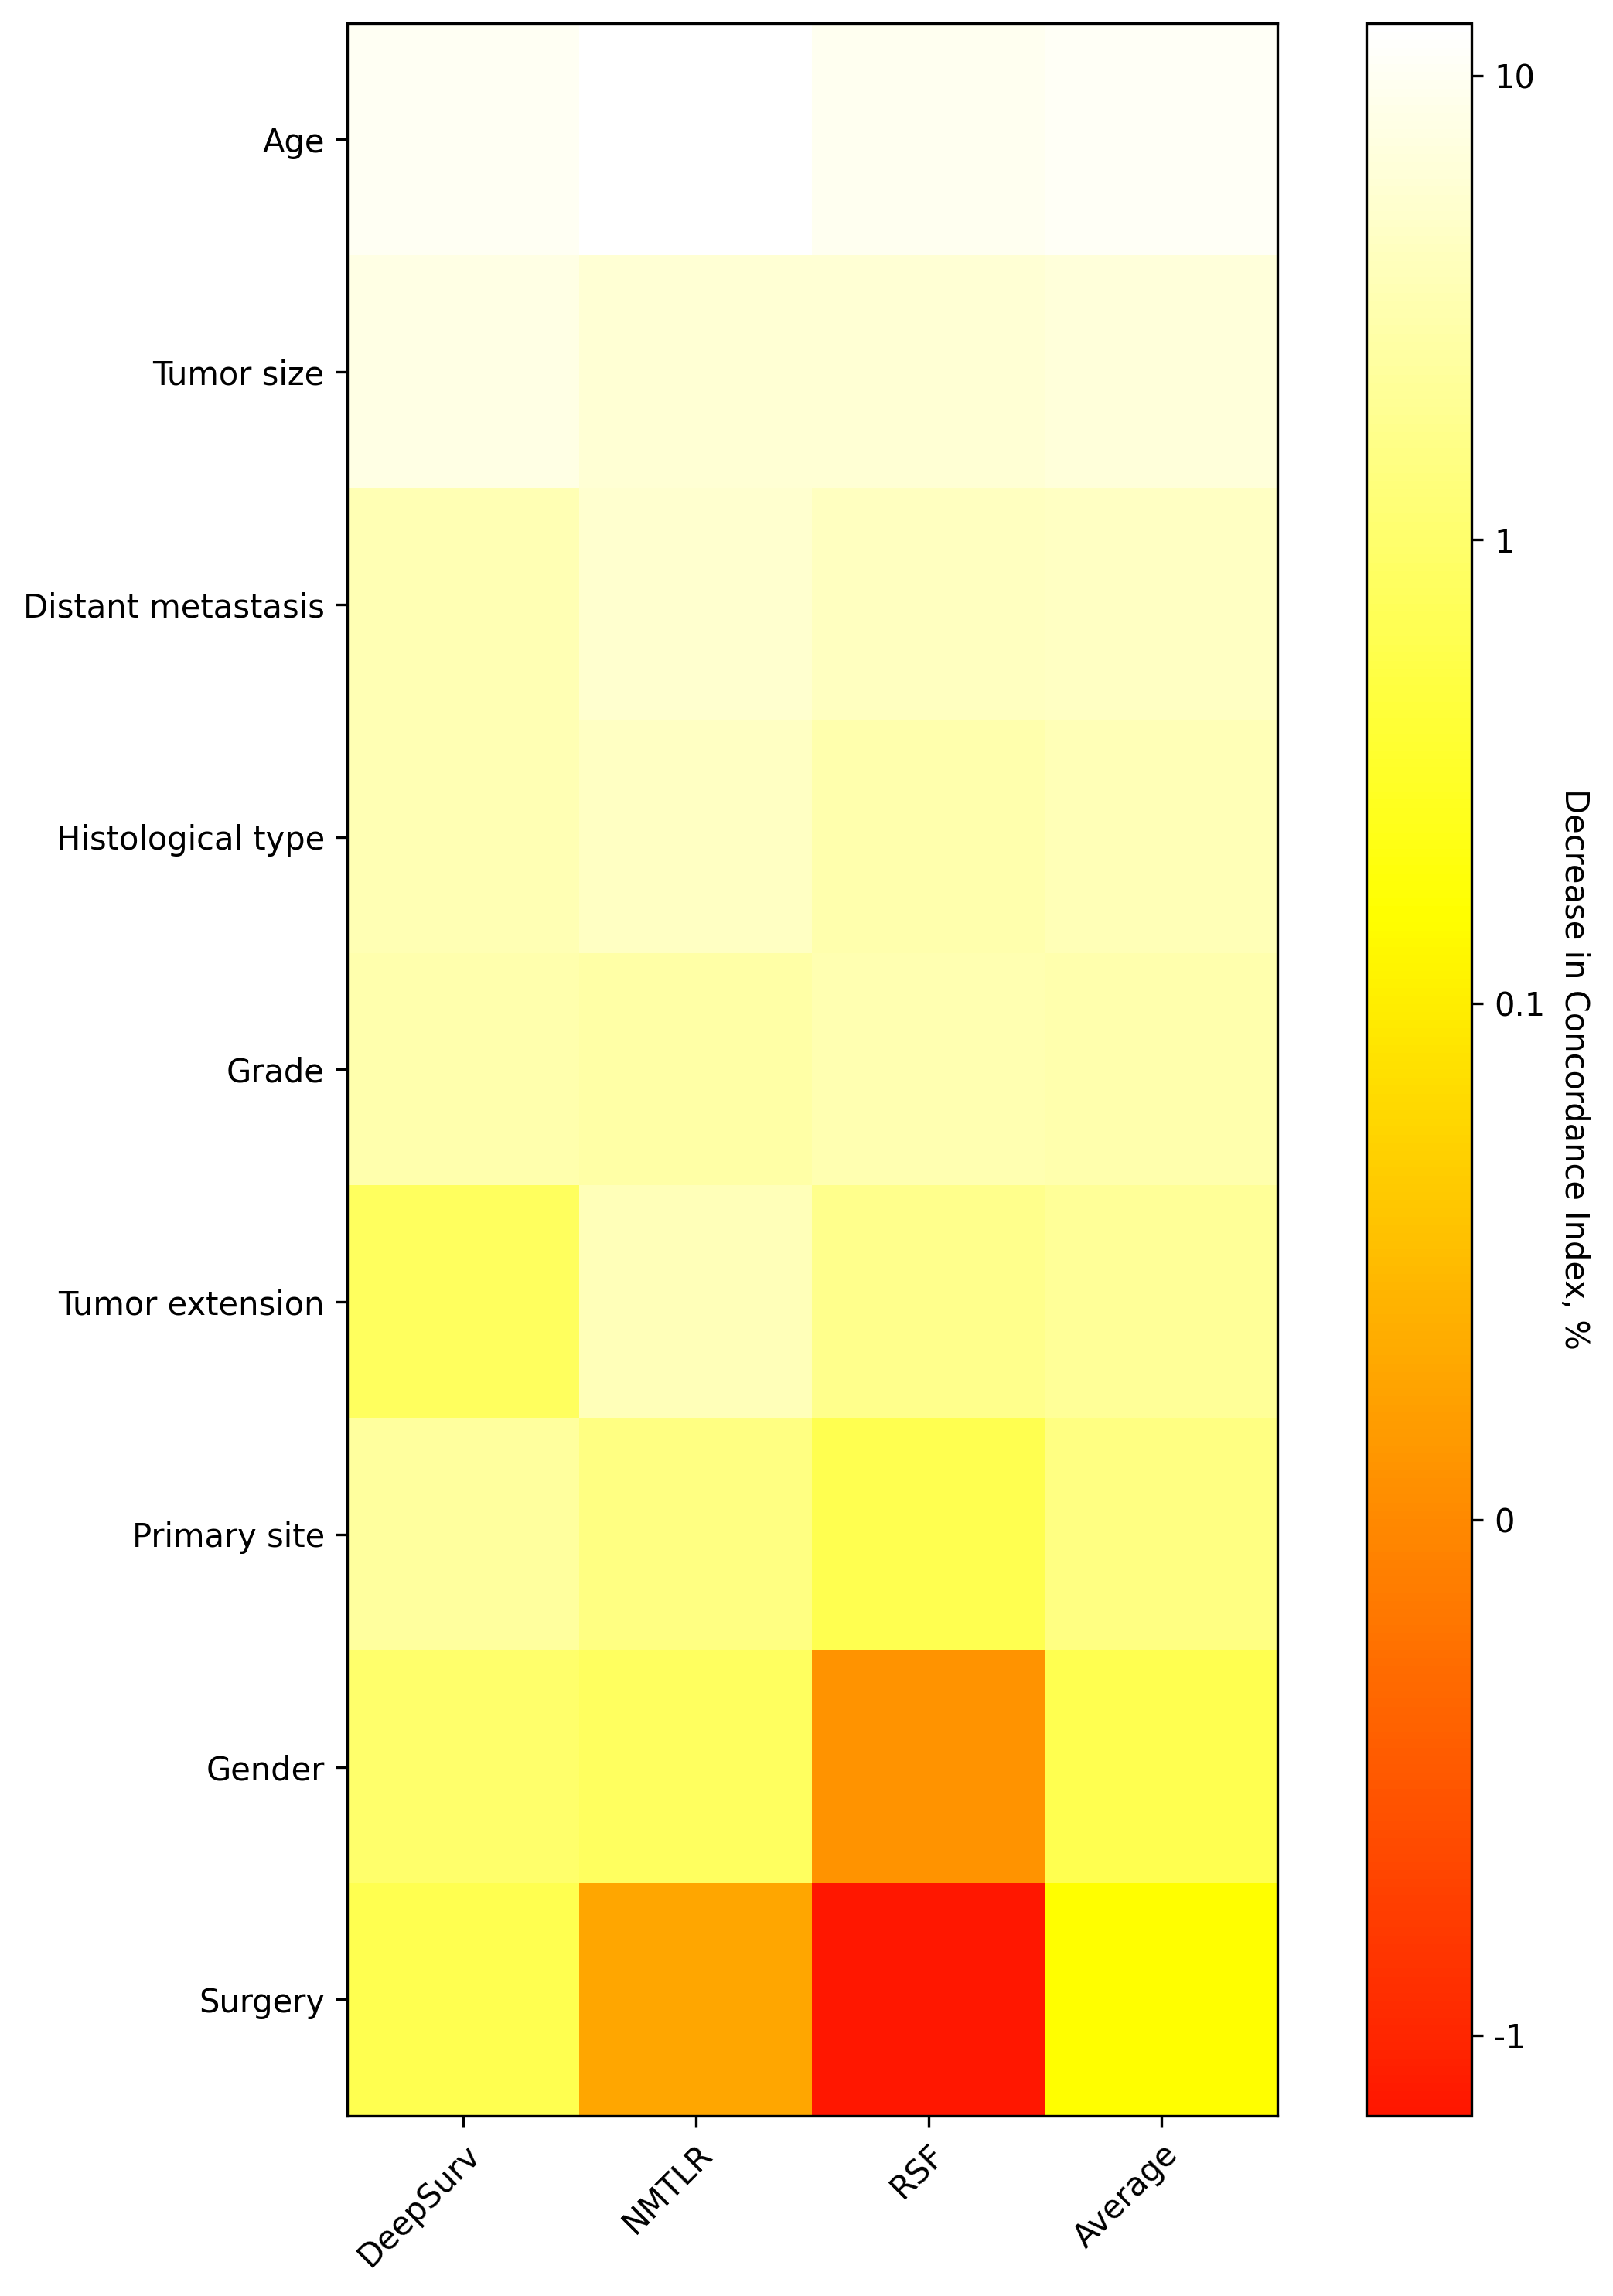

In [376]:
def plotFeatureImportance(a):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    mpl.rcParams['figure.dpi'] = 300
    # a = pd.read_csv(feature_filename)
    a = a.sort_values(by=['Average'], ascending=False)
    fig, ax = plt.subplots(figsize=(8, 10))

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    im = ax.imshow(a[['DeepSurv', 'NMTLR', 'RSF', 'Average']],
                   cmap=truncate_colormap(cm.get_cmap("hot"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-3))
    # im.set_clim(-5, -2)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Decrease in Concordance Index, %", rotation=-90, va="bottom")
    # cbar.ax.set_aspect(50)
    cbar.set_ticks([0.1,0.01,0.001,0,-0.001])
    cbar.set_ticklabels(['10',"1","0.1",0,'-1'])

    ax.set_yticks(np.arange(len(a)))
    ax.set_xticks(np.arange(len(a.columns)))
    ax.set_xticklabels(['DeepSurv', 'NMTLR', 'RSF', 'Average'])
    ax.set_yticklabels(a.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig("./Figures/variable.eps")
    plt.show()
plotFeatureImportance(imp_df)

### Save models

In [381]:
from pysurvival.utils import save_model
save_model(cph_model, os.path.join(save_path,'CoxPH.zip'))
save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
save_model(rsf.model, os.path.join(save_path,'RSF.zip'))

/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_2168/493551809.py:2: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(cph_model, os.path.join(save_path,'CoxPH.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_2168/493551809.py:3: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_2168/493551809.py:4: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/__init__

Saving the model to disk as ./output/CoxPH.zip
Saving the model to disk as ./output/DeepSurv.zip
Saving the model to disk as ./output/NMTLR.zip
Saving the model to disk as ./output/RSF.zip
